# Potentail Areas Unsupervised

In order to identify suitable areas for Urban Agriculture a unsupervised learning appraoch will be used. This notebook focuses on feature engineering for unsupervised learning.  Suitability scores will be calculated based on environment, land use and amenities. Environmetal and amenity scores are weighted and will be on a float scale between 0 and 1. Land use will be a binary score. These three features will then be used for clustering. Since environmental suitability and amenity scores are between 0 and 1, it ensures that they are on a comparable scale. The choice to make land use a binary score is based on the clear distinction between built up areas (buildings), water, and land which potentially could be used for urban agriculture. 

## Methodology
- EDA and imputation of missing values. 
- Suitablility for Urban Agriculture is split into three categories:
    - Environmental Suitability
    - Land Use Suitability
    - Amenities
- Suitability scores are calculated 
    - Weights are heuristically assigned based on research for urban agriculture and practical knowledge. 
    - Weights may be adjusted. 
    - Environmental suitability: 
        - Boundaries conducive to urban agriculture are set for different environmental features. The dataset is filtered based on these boundaries, resulting in an integer value (0 or 1) for each feature.
        - The resulting integer value (0 or 1) is then multiplied by an assigned weight. The weighted feature scores are summed to produce an overall environmental suitability score between 0 and 1. 
    - Land use suitability: 
        - df is filetered based on lulc classes, and threshold for NDBI, resulting in a binary score. 
    - Amenity score (will be in notebook Task1_modeling):
        - Group amenities into categories
        - Assign weights to categories, based on importance to urban agriculture (can be changed)
        - One hot encode amenities
        - Calculate score across row, normalize scores
        - Weight scores to get final amenity suitability score

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pykrige.uk import UniversalKriging
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('/Users/kamiasalango/Desktop/Milan_Data_Urban_Ag/zone_4_zone_9_combined_with_labels.csv')

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_13362/1654406253.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/kamiasalango/Desktop/Milan_Data_Urban_Ag/zone_4_zone_9_combined_with_labels.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739219 entries, 0 to 1739218
Data columns (total 34 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   soil_moisture                            float64
 1   NDBI                                     float64
 2   BU                                       float64
 3   Roughness                                float64
 4   Slope                                    float64
 5   NDVI                                     float64
 6   LST                                      float64
 7   UHI                                      float64
 8   UTFVI                                    float64
 9   NDWI                                     float64
 10  SAVI                                     float64
 11  lulc_classes                             int64  
 12  Amenity                                  object 
 13  GHI (kWh/m2)                             float64
 14  CH4_column_volume_

In [4]:
df.head(2)

soil_moisture      NDBI        BU  Roughness      Slope      NDVI  \
0     125.331552 -0.129746 -0.271251        0.0  89.999694  0.545336   
1     130.649125 -0.091416 -0.238252        0.0  89.999691  0.705981   

         LST       UHI     UTFVI      NDWI  ...    Typology  Year Descriptio  \
0  28.333197 -2.657156 -0.199289 -0.567614  ...  Urban farm  2007        NaN   
1  27.473296 -3.061812 -0.236826 -0.602588  ...  Urban farm  2007        NaN   

   n  distance  feature_x  feature_y  nearest_x  nearest_y  label  
0  1  0.000039   9.240700  45.419989   9.240675  45.420019      1  
1  1  0.000000   9.240341  45.420168   9.240341  45.420168      1  

[2 rows x 34 columns]

In [5]:
df['feature_y']

0          45.419989
1          45.420168
2          45.420168
3          45.420168
4          45.420168
             ...    
1739214    45.536231
1739215    45.536231
1739216    45.536231
1739217    45.536231
1739218    45.536231
Name: feature_y, Length: 1739219, dtype: float64

# Data Dictionary

## Overview
This dataset contains detailed environmental and geographical attributes to identify potential areas suitable for urban agriculture.

## Columns

| Column Name                                | Data Type | Description                                                                                               |
|--------------------------------------------|-----------|-----------------------------------------------------------------------------------------------------------|
| `soil_moisture`                            | float64   | Moisture content of the soil, measured as a percentage.                                                   |
| `NDBI`                                     | float64   | Normalized Difference Built-up Index, indicating built-up areas.                                          |
| `BU`                                       | float64   | Built-up area index.                                                                                      |
| `Roughness`                                | float64   | Surface roughness, which can affect soil erosion and water infiltration.                                  |
| `Slope`                                    | float64   | Slope of the terrain, measured in degrees.                                                                |
| `NDVI`                                     | float64   | Normalized Difference Vegetation Index, indicating vegetation health.                                      |
| `LST`                                      | float64   | Land Surface Temperature, measured in degrees Celsius.                                                    |
| `UHI`                                      | float64   | Urban Heat Island effect, indicating temperature differences between urban and rural areas.               |
| `UTFVI`                                    | float64   | Urban Thermal Field Variance Index, used to analyze urban heat patterns.                                   |
| `NDWI`                                     | float64   | Normalized Difference Water Index, indicating water content.                                               |
| `SAVI`                                     | float64   | Soil-Adjusted Vegetation Index, used to correct for soil brightness in NDVI calculations.                  |
| `lulc_classes`                             | int64     | Land use/land cover classification codes.                                                                 |
| `Amenity`                                  | object    | Description of nearby amenities.                                                                           |
| `GHI (kWh/m2)`                             | float64   | Global Horizontal Irradiance, representing solar radiation received per square meter.                     |
| `CH4_column_volume_mixing_ratio_dry_air`   | float64   | Methane concentration in the air column, measured as a mixing ratio in dry air.                           |
| `CO_column_number_density`                 | float64   | Carbon monoxide concentration in the air column, measured as a number density.                            |
| `tropospheric_HCHO_column_number_density`  | float64   | Formaldehyde concentration in the troposphere, measured as a number density.                              |
| `NO2_column_number_density`                | float64   | Nitrogen dioxide concentration in the air column, measured as a number density.                           |
| `O3_column_number_density`                 | float64   | Ozone concentration in the air column, measured as a number density.                                      |
| `SO2_column_number_density`                | float64   | Sulfur dioxide concentration in the air column, measured as a number density.                             |
| `Longitude`                                | float64   | Longitude coordinate of the data point.                                                                    |
| `Latitude`                                 | float64   | Latitude coordinate of the data point.                                                                     |
| `cover`                                    | object    | Land cover type.                                                                                           |
| `Landuse`                                  | object    | Land use type.                                                                                            |
| `Typology`                                 | object    | Typology or classification of the area.                                                                   |
| `Year`                                     | int64     | Year the data was collected.                                                                              |
| `Descriptio`                               | object    | Description of the data point or area.                                                                     |
| `n`                                        | int64     | Count or number of observations.                                                                          |
| `distance`                                 | float64   | Distance to the nearest significant feature or point of interest.                                         |
| `feature_x`                                | float64   | Longitude coordinate of a specific feature (assumed to represent the same as `Longitude`).                |
| `feature_y`                                | float64   | Latitude coordinate of a specific feature (assumed to represent the same as `Latitude`).                  |
| `nearest_x`                                | float64   | Longitude coordinate of the nearest significant feature.                                                  |
| `nearest_y`                                | float64   | Latitude coordinate of the nearest significant feature.                                                   |
| `label`                                    | int64     | Label or classification for suitability for urban agriculture.                                           |


# EDA

In [6]:
df['label'].value_counts()

label
0    1356001
1     383218
Name: count, dtype: int64

In [7]:
df.isnull().sum()

soil_moisture                                    0
NDBI                                             0
BU                                               0
Roughness                                        0
Slope                                            0
NDVI                                             0
LST                                              0
UHI                                              0
UTFVI                                            0
NDWI                                             0
SAVI                                             0
lulc_classes                                     0
Amenity                                       7310
GHI (kWh/m2)                                 17310
CH4_column_volume_mixing_ratio_dry_air     1595310
CO_column_number_density                   1595310
tropospheric_HCHO_column_number_density    1595310
NO2_column_number_density                  1595310
O3_column_number_density                   1595310
SO2_column_number_density      

In [8]:
df.shape

(1739219, 34)

**Deal with nulls**

In [9]:
#Percentage of data that is null:
#Calculate the percentage of null values for each column --> df.isnull() gives df with boolean True or False for nulls 
null_percentages = df.isnull().mean() * 100
print("Percentage of null values in each column:")
print(null_percentages)

Percentage of null values in each column:
soil_moisture                               0.000000
NDBI                                        0.000000
BU                                          0.000000
Roughness                                   0.000000
Slope                                       0.000000
NDVI                                        0.000000
LST                                         0.000000
UHI                                         0.000000
UTFVI                                       0.000000
NDWI                                        0.000000
SAVI                                        0.000000
lulc_classes                                0.000000
Amenity                                     0.420304
GHI (kWh/m2)                                0.995274
CH4_column_volume_mixing_ratio_dry_air     91.725654
CO_column_number_density                   91.725654
tropospheric_HCHO_column_number_density    91.725654
NO2_column_number_density                  91.725654
O3_c

In [10]:
df['n'].value_counts()

n
1    1739219
Name: count, dtype: int64

In [11]:
df['Descriptio'].value_counts()

Descriptio
http://www.parconord.milano.it/spazi-e-attrezzatu*    64300
"Parrocchia B.V. Immacolata E S. Antonio              34505
Parco Alessandrini                                    26796
http://www.icpezzani.gov.it/                          20011
http://www.iispareto.it/wp/                           10344
Istituto Delle Apostole Del Sacro Cuore Di Gesu' *     9816
"Scuola Secondaria di Primo Grado Giovanni Verga       9752
"http://www.coltivando.polimi.it/ Coltivando           9000
"Istituto Comprensivo Rinnovata Pizzigoni              6708
http://www.ilgiardinodegliaromi.org/                   5340
http://www.ortimissaglia.com/orto_didattico_scuol*     3644
"via Santw?TArnaldo                                    2508
http://www.fondazioneaquilone.org/                     2409
Basilica di San Calimero                               1055
Name: count, dtype: int64

In [12]:
df['Amenity'].value_counts()

Amenity
restaurant         207372
bench              197019
drinking_water     196137
waste_basket       162548
cafe               128707
                    ...  
car_sharing            81
stripclub              44
scooter_sharing        24
locker                 16
lounge                 12
Name: count, Length: 80, dtype: int64

In [13]:
#investigate amenity nulls
#filter for nulls
amenity_nulls= df[df['Amenity'].isnull()]
#look at lat and lon where amenity is null
lat_lon_amenity_nulls = amenity_nulls[['Latitude', 'Longitude']]

#print
print("Latitude and Longitude of rows with null 'Amenity' values:")
print(lat_lon_amenity_nulls)

Latitude and Longitude of rows with null 'Amenity' values:
          Latitude  Longitude
1010909  45.531559   9.178536
1010910  45.531559   9.178716
1010911  45.531559   9.178896
1010912  45.531559   9.179075
1010913  45.531559   9.179255
...            ...        ...
1739214  45.536231   9.174045
1739215  45.536231   9.174225
1739216  45.536231   9.174404
1739217  45.536231   9.174584
1739218  45.536231   9.174763

[7310 rows x 2 columns]


In [14]:
import folium


In [15]:
if not lat_lon_amenity_nulls.empty:
    map_center = [lat_lon_amenity_nulls['Latitude'].mean(), lat_lon_amenity_nulls['Longitude'].mean()]
    amenity_map = folium.Map(location=map_center, zoom_start=12)

    #Add points to the map
    for _, row in lat_lon_amenity_nulls.iterrows():
        folium.Marker(location=[row['Latitude'], row['Longitude']]).add_to(amenity_map)

    #Display the map
    amenity_map.save("amenity_nulls_map.html")
    print("Map of rows with null 'Amenity' values saved as 'amenity_nulls_map.html'.")
else:
    print("No rows with null 'Amenity' values to display on the map.")

Map of rows with null 'Amenity' values saved as 'amenity_nulls_map.html'.


In [16]:
#impute missing Amenity vals with "unknown", only 0.4% of amenity data is missing
df['Amenity'].fillna('Unknown', inplace=True)


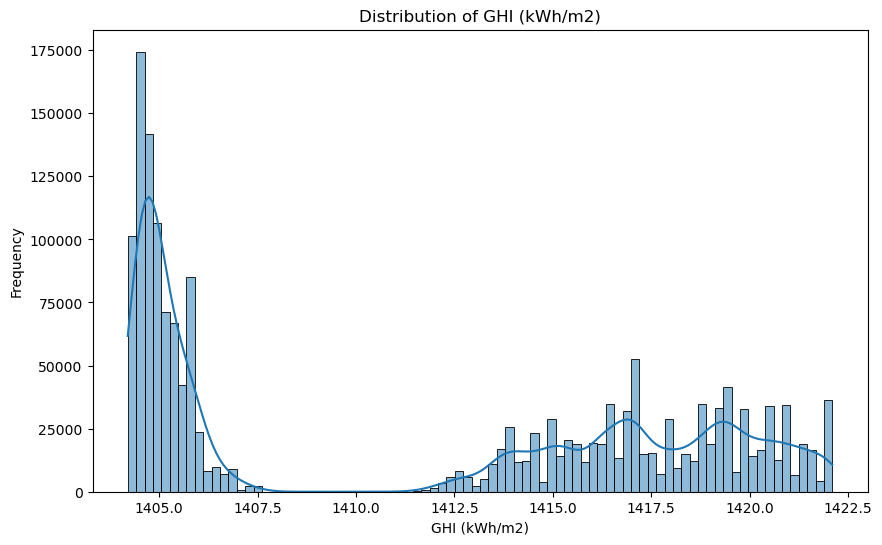

In [17]:
#GHI 
#Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['GHI (kWh/m2)'].dropna(), kde=True)
plt.title('Distribution of GHI (kWh/m2)')
plt.xlabel('GHI (kWh/m2)')
plt.ylabel('Frequency')
plt.show()

A range of 1405 to 1422.5 kWh/m² is relatively narrow, suggesting that the location has a consistent solar radiation level. Missing values will be imputed with median, as the distribution is right skewed, imputations will be less affected by outliers. 

In [18]:
#Calculate median
median_ghi = df['GHI (kWh/m2)'].median()

#Impute missing 'GHI (kWh/m2)' values with the median
df['GHI (kWh/m2)'].fillna(median_ghi, inplace=True)

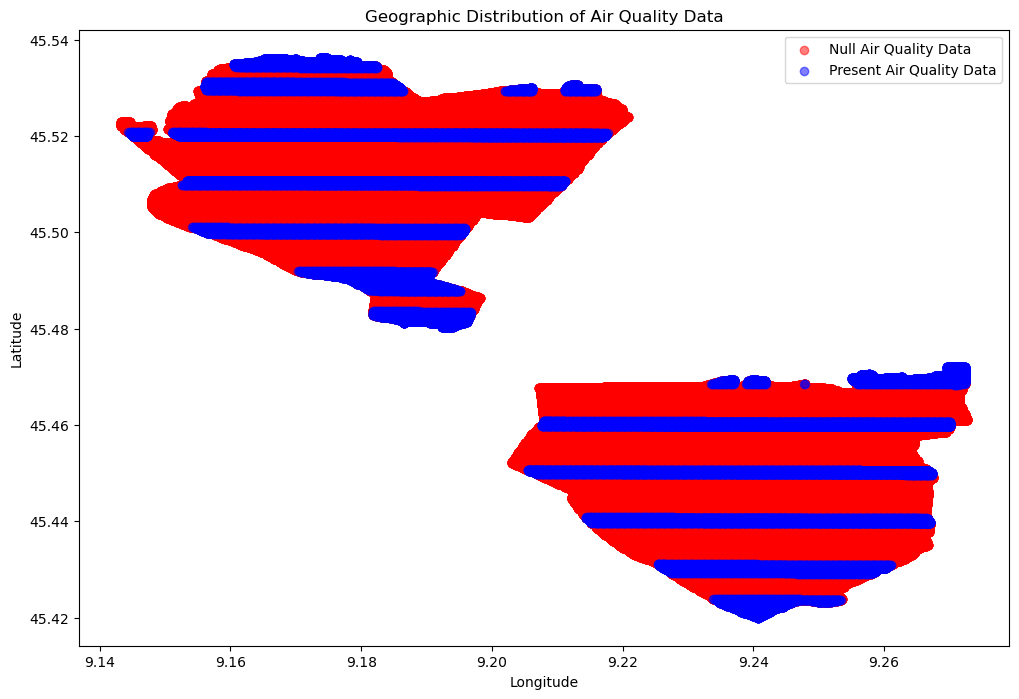

In [19]:
air_quality_cols = ['CH4_column_volume_mixing_ratio_dry_air', 'CO_column_number_density',
                     'tropospheric_HCHO_column_number_density', 'NO2_column_number_density', 
                     'O3_column_number_density', 'SO2_column_number_density']

# Create a DataFrame to indicate missing values
missing_data = df[air_quality_cols].isnull()

# Filter rows where any air quality data is null
air_quality_nulls = df[missing_data.any(axis=1)]

# Filter rows where all air quality data is present
air_quality_non_nulls = df[~missing_data.any(axis=1)]

# Plot the geographic distribution
plt.figure(figsize=(12, 8))

# Plot where air quality data is missing
plt.scatter(air_quality_nulls['Longitude'], air_quality_nulls['Latitude'], alpha=0.5, color='red', label='Null Air Quality Data')

# Plot where air quality data is present
plt.scatter(air_quality_non_nulls['Longitude'], air_quality_non_nulls['Latitude'], alpha=0.5, color='blue', label='Present Air Quality Data')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Air Quality Data')
plt.legend()
plt.show()

In [20]:

from skgstat import Variogram
import matplotlib.pyplot as plt

In [21]:
#function for semivariogram (look at spatial autocorrelation of air quality), use sample as data set is large --> kernel crash
def plot_semivariogram_sampled(data, column, lon_col='Longitude', lat_col='Latitude', sample_size=1000):
    # Drop rows with missing values in the target column
    data = data.dropna(subset=[column])
    
    # Randomly sample the data to reduce the computational load
    if len(data) > sample_size:
        data = data.sample(sample_size, random_state=42)
    
    # Extract coordinates and values
    coordinates = data[[lon_col, lat_col]].values
    values = data[column].values
    
    # Create the Variogram object
    V = Variogram(coordinates, values, model='exponential')
    
    # Plot the semivariogram
    fig = V.plot(show=False)
    plt.title(f'Semivariogram for {column} (Sampled)')
    plt.show()



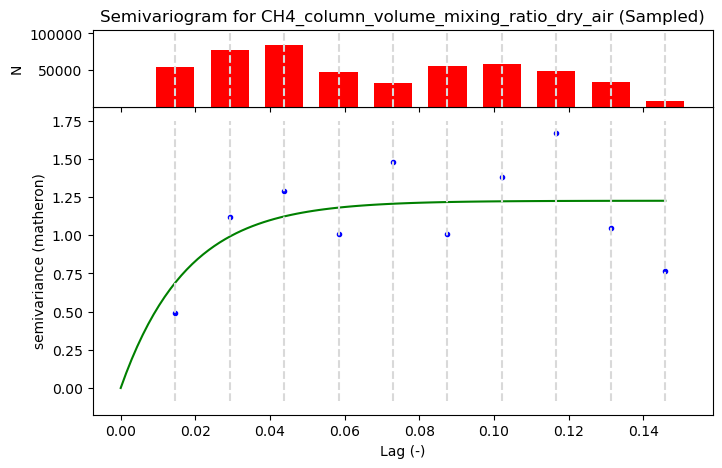

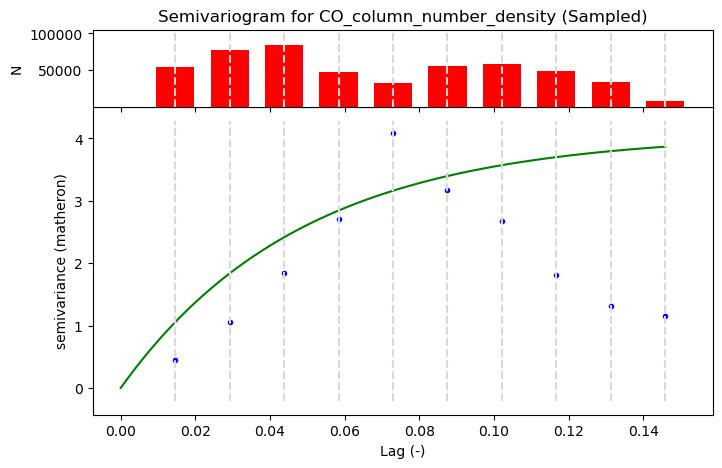

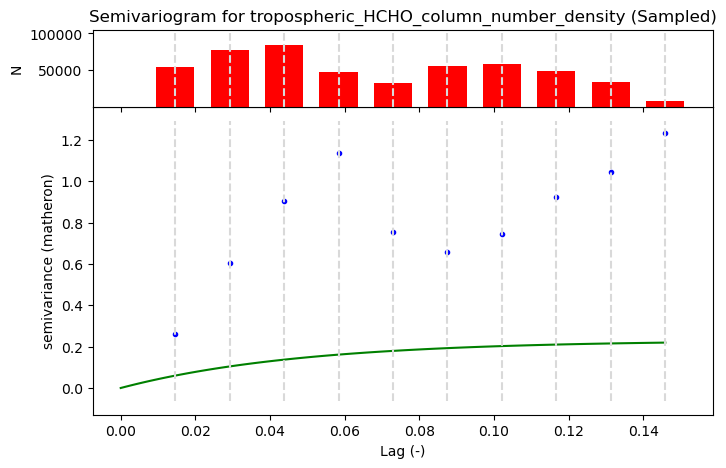

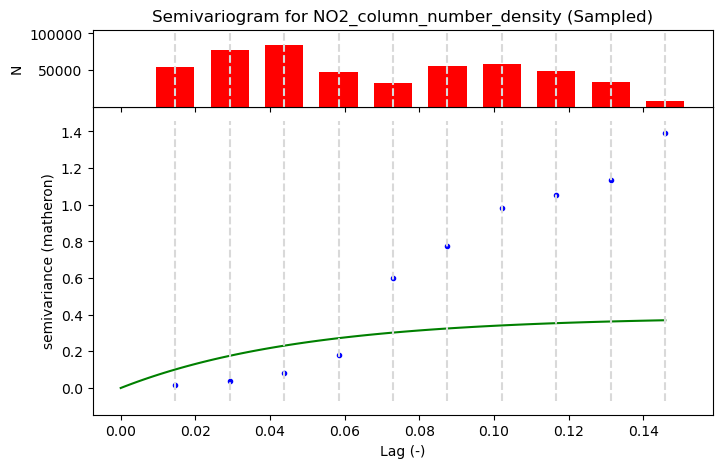

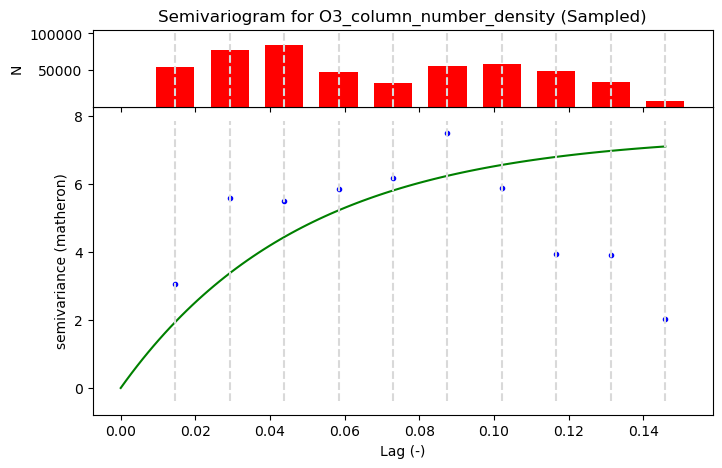

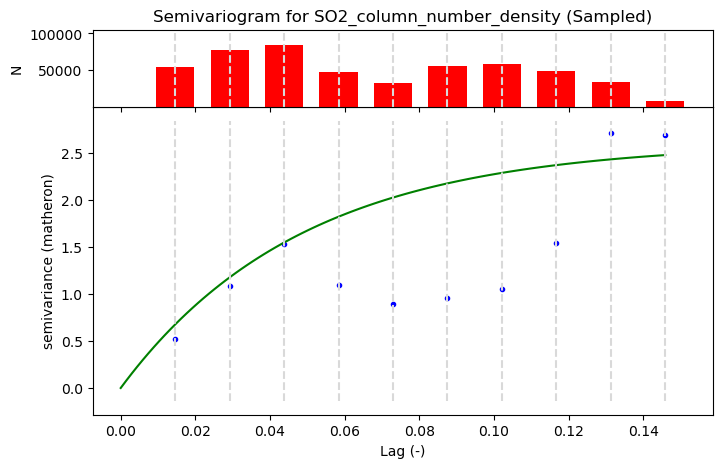

In [22]:
#air quaility cols to list
air_quality_cols = [
    'CH4_column_volume_mixing_ratio_dry_air',
    'CO_column_number_density',
    'tropospheric_HCHO_column_number_density',
    'NO2_column_number_density',
    'O3_column_number_density',
    'SO2_column_number_density'
]
#apply function for semivariogram
for col in air_quality_cols:
    plot_semivariogram_sampled(df, col)

CH4 seems to display a clear leveling off around lag 0.05, all other air quaility graphs display somewhat of a leveling off around 0.05-0.09, for KNN imputation k will be calculated using 0.05 as the range for autocorrelation. 

In [23]:
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors

In [24]:
# Function to calculate k based on spatial density and range using a sample of the data
def estimate_k_based_on_sample(data, lon_col='Longitude', lat_col='Latitude', range_distance=0.05, sample_size=1000):
    # Sample the data to reduce computational load
    sampled_data = data.sample(sample_size, random_state=42)
    
    # Extract coordinates from the sampled data
    coordinates = sampled_data[[lon_col, lat_col]].values
    
    # Fit NearestNeighbors to find distances to the k-nearest neighbors
    nbrs = NearestNeighbors(radius=range_distance).fit(coordinates)
    
    # Find the number of neighbors within the range distance
    distances, indices = nbrs.radius_neighbors(coordinates)
    k_values = [len(neighbors) for neighbors in indices]
    
    # Estimate k as the median number of neighbors within the range distance
    estimated_k = int(np.median(k_values))
    return estimated_k

In [26]:
#calculate k based on the range
estimated_k = estimate_k_based_on_sample(df, range_distance=0.05)
print(f"Estimated k value based on spatial correlation range: {estimated_k}")

Estimated k value based on spatial correlation range: 485


Using K nearest neighbours or Kriging method is too computationally expensive. A strip based imputation will be used and semivariograms of air quaility cols will be assessed before and after imputation to verify if spatial correlation is maintained. 

In [29]:
#function to segment data into strips
def seg_strips(data, lat_col = 'Latitude', strip_width = 0.01):
    data['strip_id'] = (data[lat_col]// strip_width).astype(int)
    return data

In [37]:
#function to find the nearest strip with data
def find_nearest_strip_with_data(data, current_strip, direction, air_quality_cols):
    step = 1 if direction == 'up' else -1
    strip_id = current_strip + step
    while strip_id in data['strip_id'].unique():
        strip_data = data[data['strip_id'] == strip_id]
        if not strip_data[air_quality_cols].isnull().all().all():
            return strip_data[air_quality_cols].mean() #take average
        strip_id += step
    return None


In [40]:
# Function to impute using the average of neighboring strips
def strip_based_average_imputation(data, air_quality_cols, lat_col='Latitude', strip_width=0.01):
    # Segment the data into strips
    data = seg_strips(data, lat_col, strip_width)
    
    # Iterate through each strip and impute missing values
    for strip_id in data['strip_id'].unique():
        strip_data = data[data['strip_id'] == strip_id].copy()
        
        if strip_data[air_quality_cols].isnull().any().any():
            upper_strip_avg = find_nearest_strip_with_data(data, strip_id, 'up', air_quality_cols)
            lower_strip_avg = find_nearest_strip_with_data(data, strip_id, 'down', air_quality_cols)
            
            if upper_strip_avg is not None and lower_strip_avg is not None:
                averages = (upper_strip_avg + lower_strip_avg) / 2
            elif upper_strip_avg is not None:
                averages = upper_strip_avg
            elif lower_strip_avg is not None:
                averages = lower_strip_avg
            else:
                averages = None  # No neighboring data found
            
            if averages is not None:
                for col in air_quality_cols:
                    strip_data.loc[strip_data[col].isnull(), col] = averages[col]
        
        # Update the main data with the imputed values using .loc
        data.loc[strip_data.index, air_quality_cols] = strip_data[air_quality_cols]
    
    # Drop the strip_id column
    data.drop(columns=['strip_id'], inplace=True)
    return data


In [41]:
#apply strip based imputation using averages

df = strip_based_average_imputation(df, air_quality_cols)

In [46]:
#Function to plot distributions in a grid layout
def plot_distributions_grid(df, columns):
    num_cols = 2
    num_rows = (len(columns) + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.kdeplot(df[col], label='All Values', color='red', shade=True, ax=axes[i])
        
        # Plot only imputed values (assuming they were originally NaN)
        imputed_values = df[df[col].isna()][col]
        sns.kdeplot(imputed_values, label='Imputed Values', color='blue', linestyle='--', shade=True, ax=axes[i])
        
        axes[i].set_title(f'Distribution of {col} After Imputation')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_13362/1557493470.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], label='All Values', color='red', shade=True, ax=axes[i])
/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_13362/1557493470.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(imputed_values, label='Imputed Values', color='blue', linestyle='--', shade=True, ax=axes[i])
/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_13362/1557493470.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], label='All Values', color='red', shade=True, ax=axes[i])
/var/folders/h5

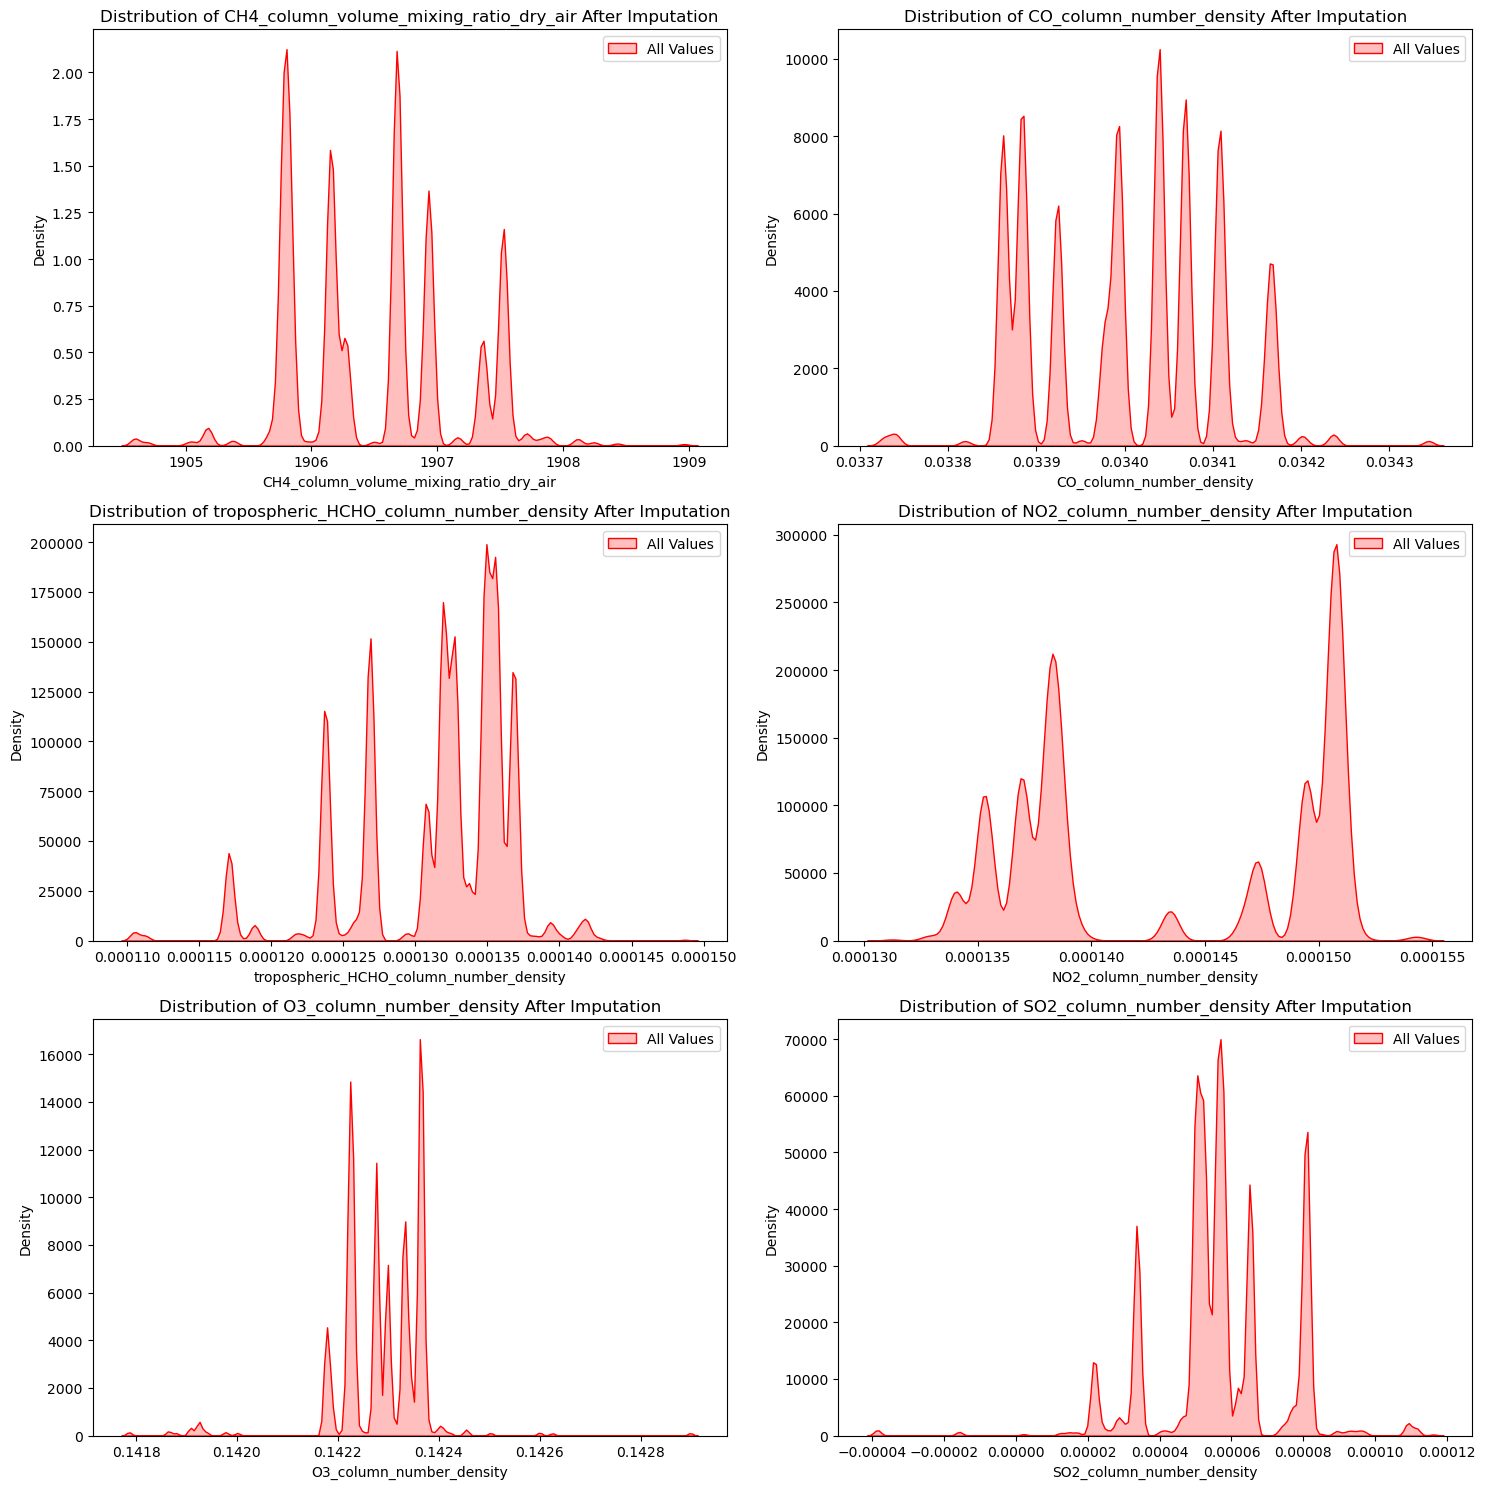

In [47]:
plot_distributions_grid(df, air_quality_cols)

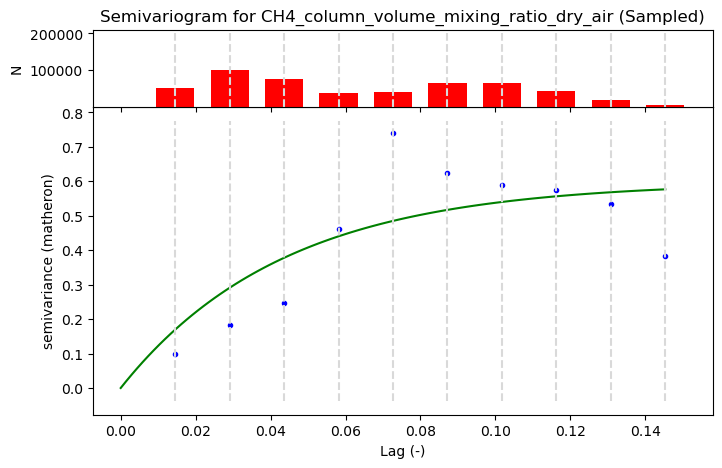

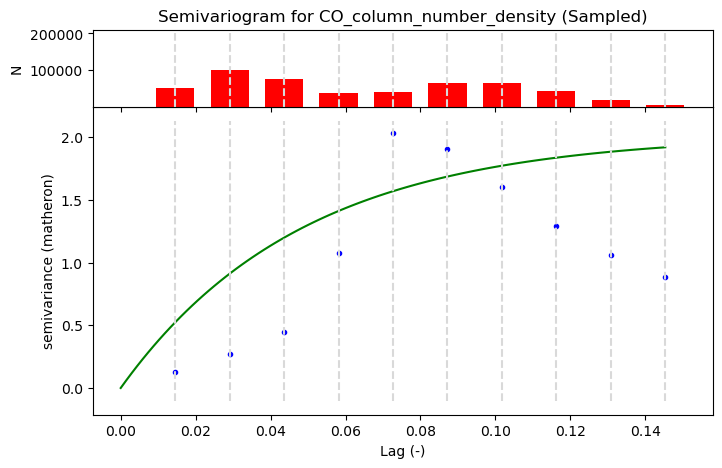

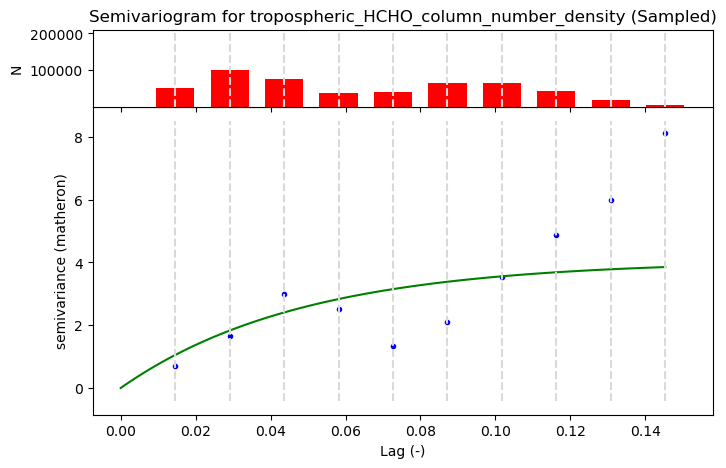

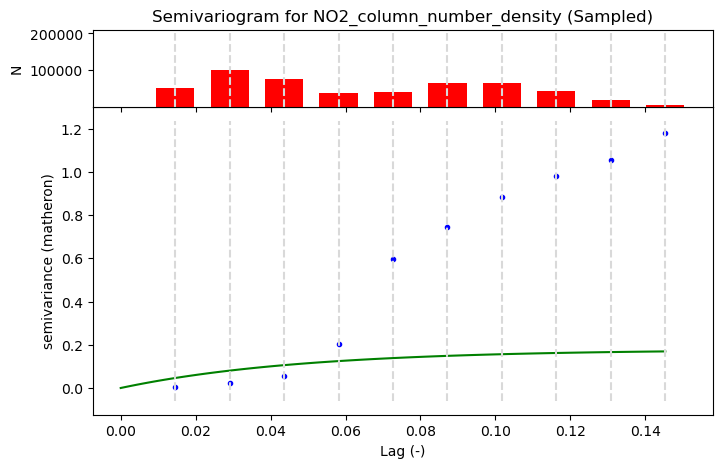

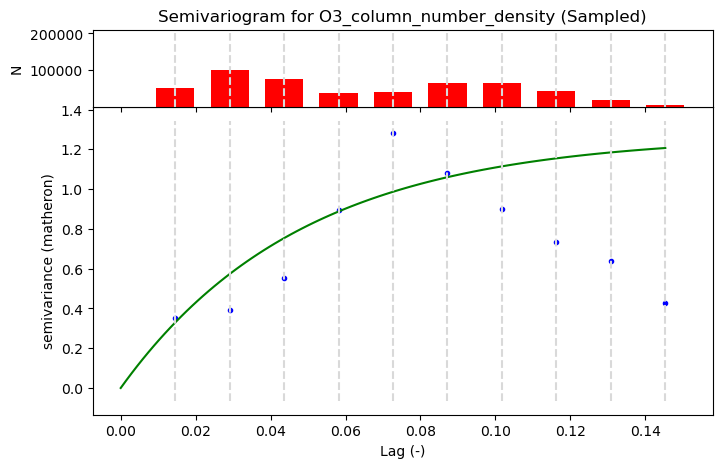

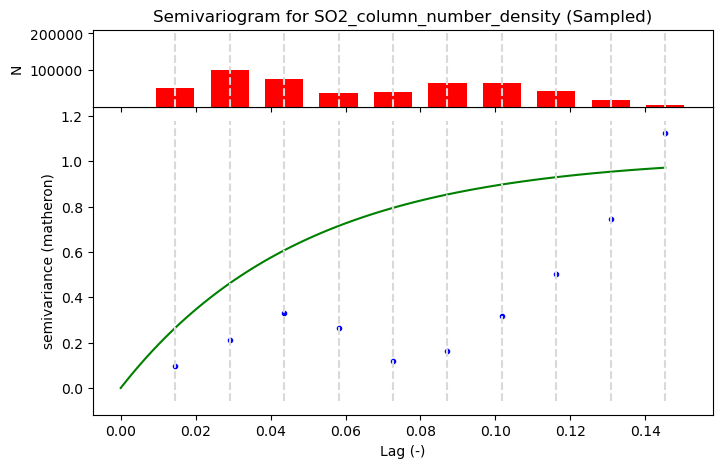

In [48]:
#compare semiovariograms from before imputation: 
for col in air_quality_cols:
    plot_semivariogram_sampled(df, col)

Based on Semivariogram comparison of the air quality cols, before and after the strip based imputation, it appears that semivariograms are similar and follow same broad general pattern for each air quaility col, therefore imputation has somewhat maintained spatial correlation that was present in data. For now this imputation will be left and air quailty cols may possibly used in modelling. 

In [50]:
#deal wtih description nulls
df['Descriptio'].fillna( 'None', inplace =True)

In [51]:
#check entire df for nulls
df.isnull().sum()

soil_moisture                              0
NDBI                                       0
BU                                         0
Roughness                                  0
Slope                                      0
NDVI                                       0
LST                                        0
UHI                                        0
UTFVI                                      0
NDWI                                       0
SAVI                                       0
lulc_classes                               0
Amenity                                    0
GHI (kWh/m2)                               0
CH4_column_volume_mixing_ratio_dry_air     0
CO_column_number_density                   0
tropospheric_HCHO_column_number_density    0
NO2_column_number_density                  0
O3_column_number_density                   0
SO2_column_number_density                  0
Longitude                                  0
Latitude                                   0
cover     

In [52]:
df['Year'].value_counts()

Year
2007    1542756
2014     196463
Name: count, dtype: int64

### Categorical Variables

- Amenity (object)
- cover (object)
- Landuse (object)
- Typology (object)
- Descriptio (object)
- lulc_classes (int64, assuming it represents categorical land use/land cover classes)
- Year (int64, if it's treated as a category rather than a continuous variable)
- label (int64, assuming it's a categorical label)


In [54]:
df['Amenity'].value_counts()

Amenity
restaurant         207372
bench              197019
drinking_water     196137
waste_basket       162548
cafe               128707
                    ...  
car_sharing            81
stripclub              44
scooter_sharing        24
locker                 16
lounge                 12
Name: count, Length: 81, dtype: int64

In [55]:
df['cover'].value_counts()

cover
c    1705391
p      33828
Name: count, dtype: int64

In [56]:
df['Landuse'].value_counts()

Landuse
Horticulture                1227981
Arable crops                 357125
nurseries - floriculture     121684
Mixed crops                   17765
Orchards                      14664
Name: count, dtype: int64

In [57]:
df['Typology'].value_counts()

Typology
Residential garden      732022
Urban farm              383218
Community garden        331994
nurseries               121684
Institutional garden    121368
Illegal garden           48933
Name: count, dtype: int64

In [58]:
df['lulc_classes'].value_counts()

lulc_classes
6    1469514
1     126800
2      66277
4      63386
0       6435
7       6075
5        732
Name: count, dtype: int64

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739219 entries, 0 to 1739218
Data columns (total 34 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   soil_moisture                            float64
 1   NDBI                                     float64
 2   BU                                       float64
 3   Roughness                                float64
 4   Slope                                    float64
 5   NDVI                                     float64
 6   LST                                      float64
 7   UHI                                      float64
 8   UTFVI                                    float64
 9   NDWI                                     float64
 10  SAVI                                     float64
 11  lulc_classes                             int64  
 12  Amenity                                  object 
 13  GHI (kWh/m2)                             float64
 14  CH4_column_volume_

# Suitablity Scores

The data will be divided into 3 groupings; environmental conditions, land use and amenities. A suitability score for urban agriculture will be calculated for each grouping and the data will be filtered to meet suitability for Urban agriculture.

- Environmental conditions: Suitablity score will be based on assumption that soil is available in the space, therefore variables soil moisture, NDWI, SAVI, and NDVI will be considered. 

- Land Use: 

- Amenities: 

### Environmental Conditions

Boundaries are defined based on research on suitability for growing crops: 

- Soil Moisture (soil_moisture): 20% - 40%
- Slope (Slope): 0% - 5%
- NDVI (NDVI): NDVI > 0.3
- Land Surface Temperature (LST): 15°C - 30°C
- Urban Heat Island (UHI): Suitable range depending on urban planning guidelines
- Urban Thermal Field Variance Index (UTFVI): Lower values are generally better
- NDWI (NDWI): NDWI > 0
- Soil Adjusted Vegetation Index (SAVI): SAVI > 0
- Global Horizontal Irradiance (GHI (kWh/m2)): GHI > 4.5 kWh/m²
- Air Quality (CH4, CO, HCHO, NO2, O3, SO2): Lower concentrations are generally better




In [67]:
env_variables = [
    'soil_moisture', 'Slope', 'NDVI', 'LST', 'UHI', 'UTFVI', 
    'NDWI', 'SAVI', 'GHI (kWh/m2)', 'CH4_column_volume_mixing_ratio_dry_air', 
    'CO_column_number_density', 'tropospheric_HCHO_column_number_density', 
    'NO2_column_number_density', 'O3_column_number_density', 'SO2_column_number_density'
]

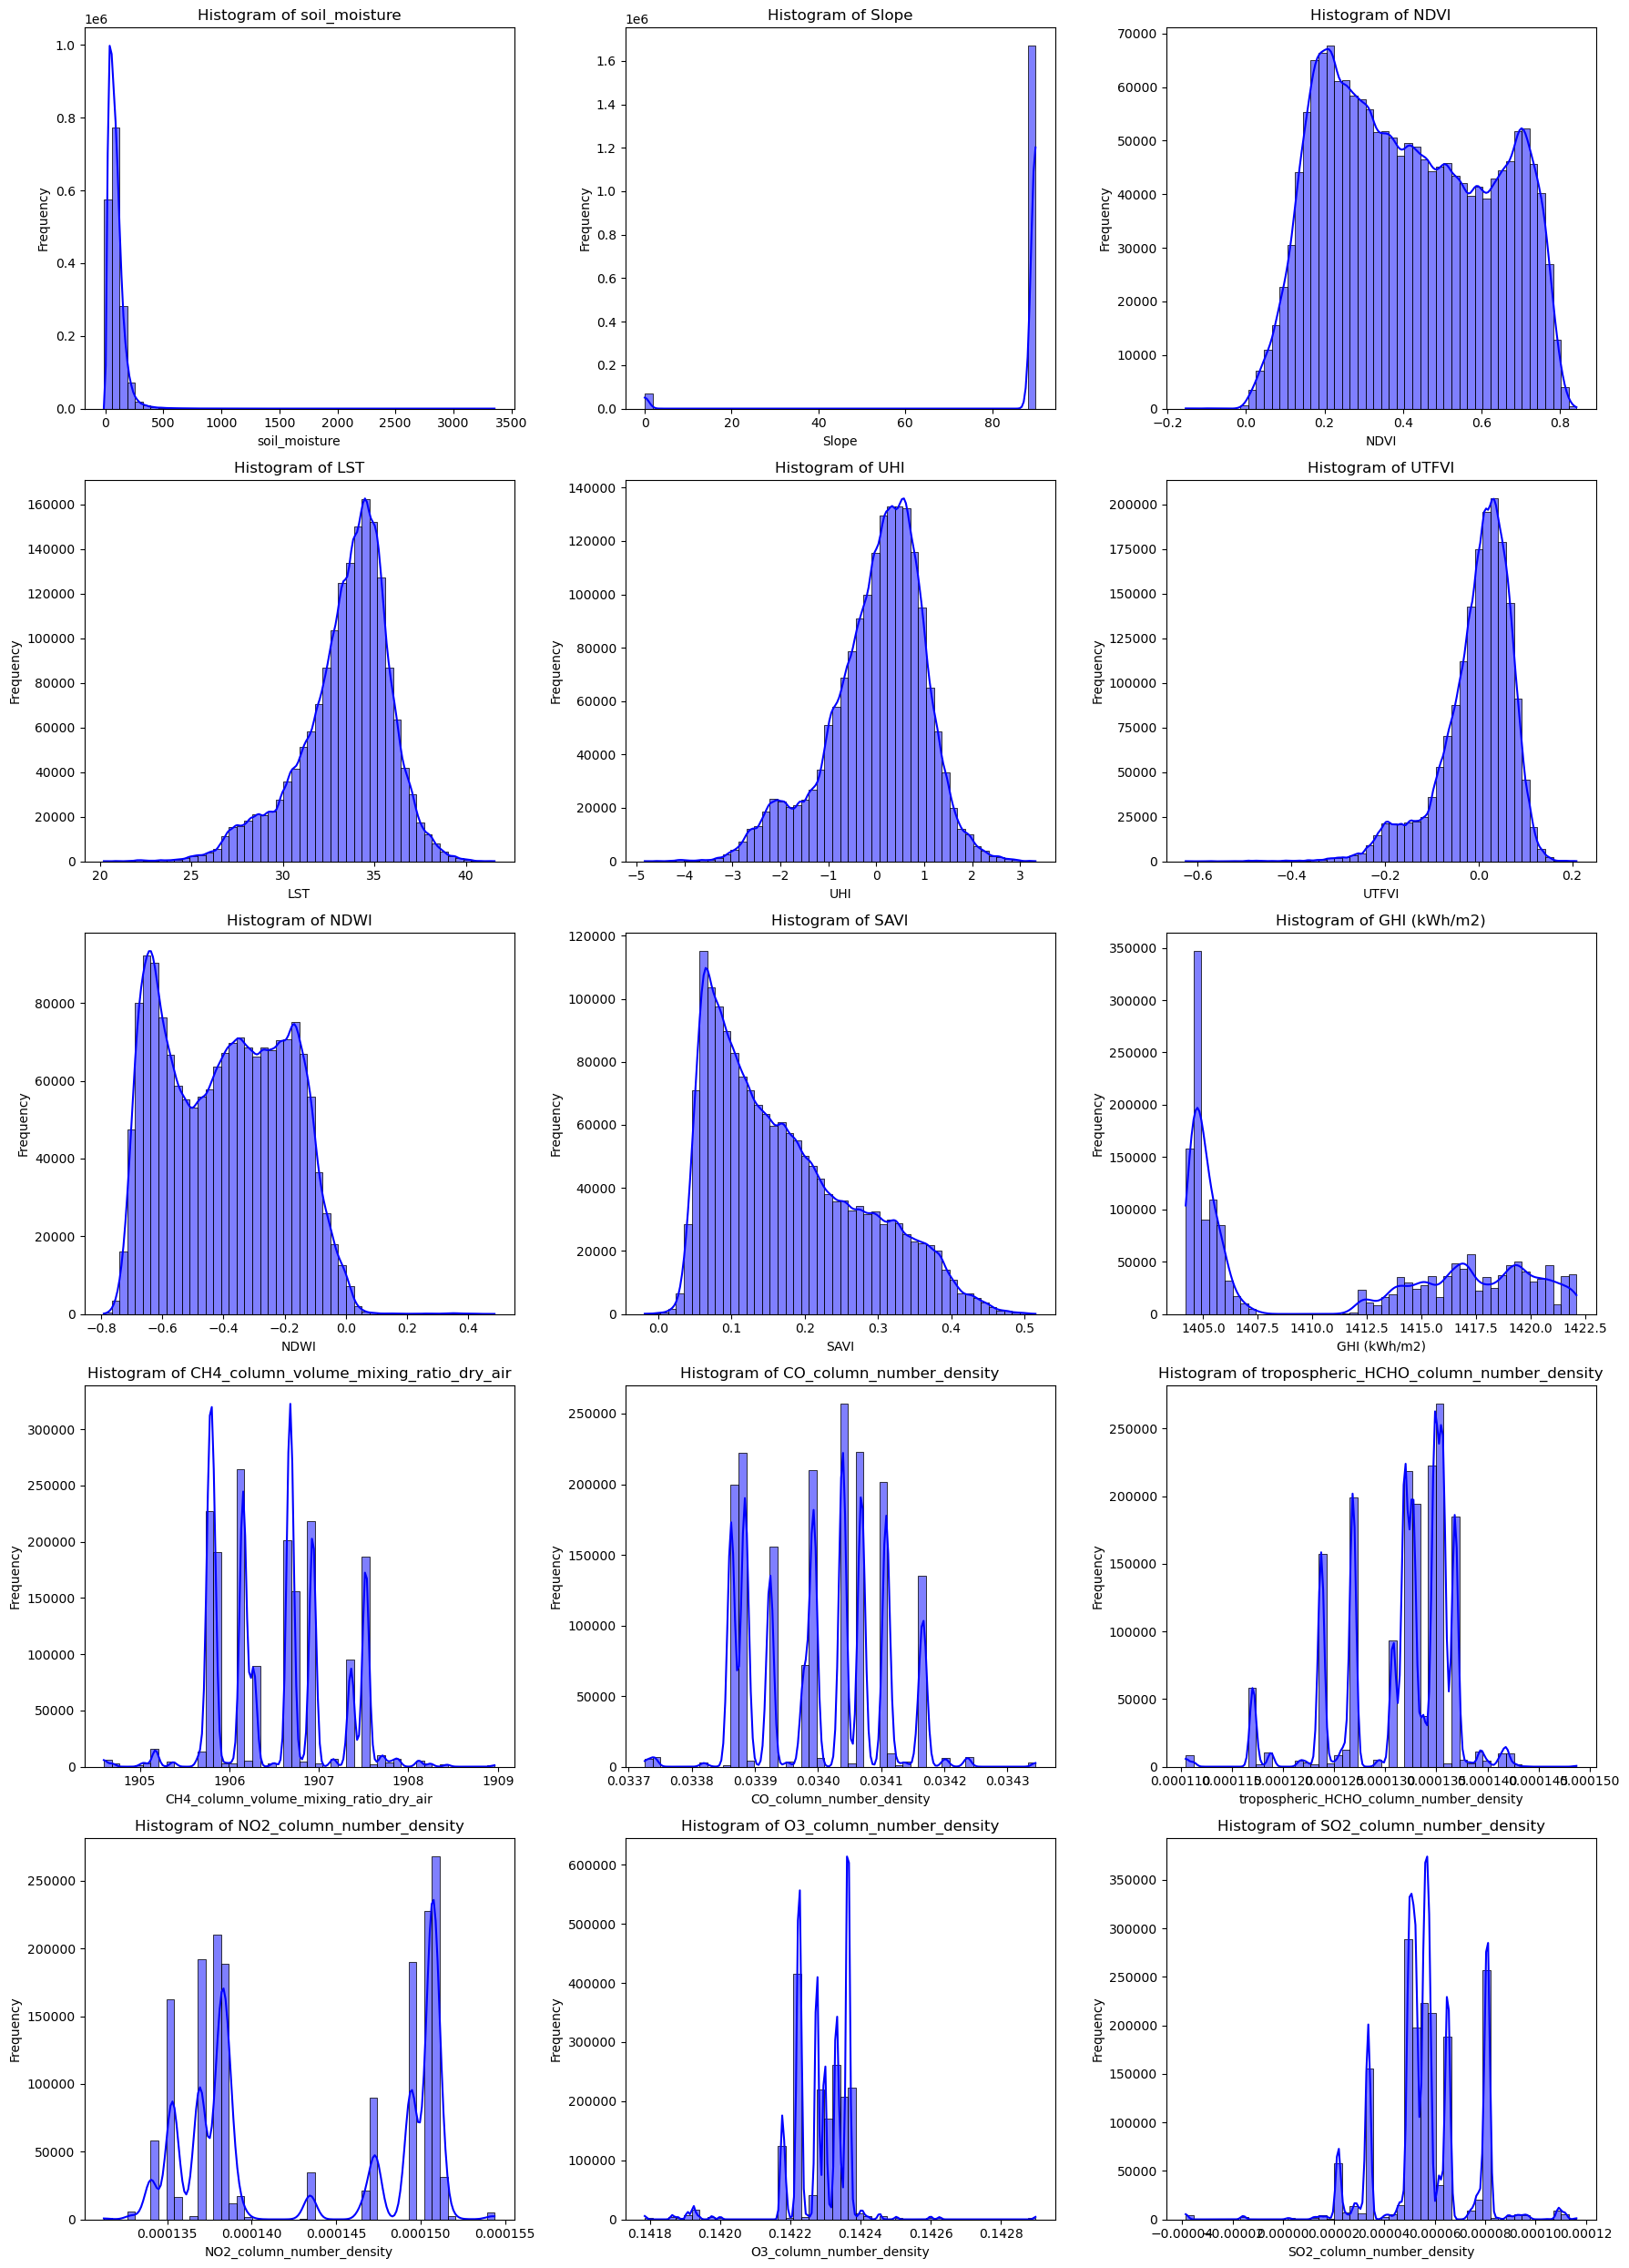

In [68]:
n_rows = 5
n_cols = 3

#figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 25))

#flatten the axes array for easy iteration
axes = axes.flatten()

#plot histograms for each variable
for i, var in enumerate(variables):
    sns.histplot(df[var], bins=50, kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Histogram of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

#remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [69]:
#set boundaries for suitability for urban agriculture
soil_moisture_min, soil_moisture_max = 20, 40
ndvi_min = 0.3
solar_min = 4.5
lst_min, lst_max = 15, 30
uhi_max = 2  # Example threshold for UHI; adjust based on specific context
utfvi_max = 1  # Example threshold for UTFVI
slope_max = 5
ndwi_min = 0  # NDWI should be above zero
savi_min = 0  # SAVI should be above zero
air_quality_max = {
    'CH4': 1.8,  
    'CO': 0.9,   
    'HCHO': 0.05, 
    'NO2': 0.05, 
    'O3': 0.07,  
    'SO2': 0.005 
}

In [70]:
#weight each suitability score (can be adjusted--> based on relative interpretation of importance of variubale in urban ag)
weights = {
    'soil_moisture_suitable': 0.15,
    'slope_suitable': 0.1,
    'ndvi_suitable': 0.15,
    'lst_suitable': 0.1,
    'uhi_suitable': 0.1,
    'utfvi_suitable': 0.05,
    'ndwi_suitable': 0.1,
    'savi_suitable': 0.1,
    'ghi_suitable': 0.05,
    'air_quality_suitable': 0.1
}

In [72]:
#create individual criteria columns
df['soil_moisture_suitable'] = ((df['soil_moisture'] >= soil_moisture_min) & (df['soil_moisture'] <= soil_moisture_max)).astype(int)
df['slope_suitable'] = (df['Slope'] <= slope_max).astype(int)
df['ndvi_suitable'] = (df['NDVI'] > ndvi_min).astype(int)
df['lst_suitable'] = ((df['LST'] >= lst_min) & (df['LST'] <= lst_max)).astype(int)
df['uhi_suitable'] = (df['UHI'] <= uhi_max).astype(int)
df['utfvi_suitable'] = (df['UTFVI'] <= utfvi_max).astype(int)
df['ndwi_suitable'] = (df['NDWI'] > ndwi_min).astype(int)
df['savi_suitable'] = (df['SAVI'] > savi_min).astype(int)
df['ghi_suitable'] = (df['GHI (kWh/m2)'] > solar_min).astype(int)

#air quality criteria
df['air_quality_suitable'] = (
    (df['CH4_column_volume_mixing_ratio_dry_air'] <= air_quality_max['CH4']) &
    (df['CO_column_number_density'] <= air_quality_max['CO']) &
    (df['tropospheric_HCHO_column_number_density'] <= air_quality_max['HCHO']) &
    (df['NO2_column_number_density'] <= air_quality_max['NO2']) &
    (df['O3_column_number_density'] <= air_quality_max['O3']) &
    (df['SO2_column_number_density'] <= air_quality_max['SO2'])
).astype(int)


In [73]:
# Calculate the weighted environmental suitability score
df['env_suitability_score'] = (
    df['soil_moisture_suitable'] * weights['soil_moisture_suitable'] +
    df['slope_suitable'] * weights['slope_suitable'] +
    df['ndvi_suitable'] * weights['ndvi_suitable'] +
    df['lst_suitable'] * weights['lst_suitable'] +
    df['uhi_suitable'] * weights['uhi_suitable'] +
    df['utfvi_suitable'] * weights['utfvi_suitable'] +
    df['ndwi_suitable'] * weights['ndwi_suitable'] +
    df['savi_suitable'] * weights['savi_suitable'] +
    df['ghi_suitable'] * weights['ghi_suitable'] +
    df['air_quality_suitable'] * weights['air_quality_suitable']
)

# Drop the extra suitability columns
df.drop(columns=[
    'soil_moisture_suitable', 'slope_suitable', 'ndvi_suitable', 
    'lst_suitable', 'uhi_suitable', 'utfvi_suitable', 
    'ndwi_suitable', 'savi_suitable', 'ghi_suitable', 
    'air_quality_suitable'
], inplace=True)

In [74]:
df['env_suitability_score'].value_counts()

env_suitability_score
0.45    989190
0.30    403982
0.55    175031
0.60     91013
0.40     40441
0.70     17725
0.20     10881
0.65      5535
0.35      3290
0.50       827
0.80       679
0.50       604
0.75        13
0.35         6
0.45         2
Name: count, dtype: int64

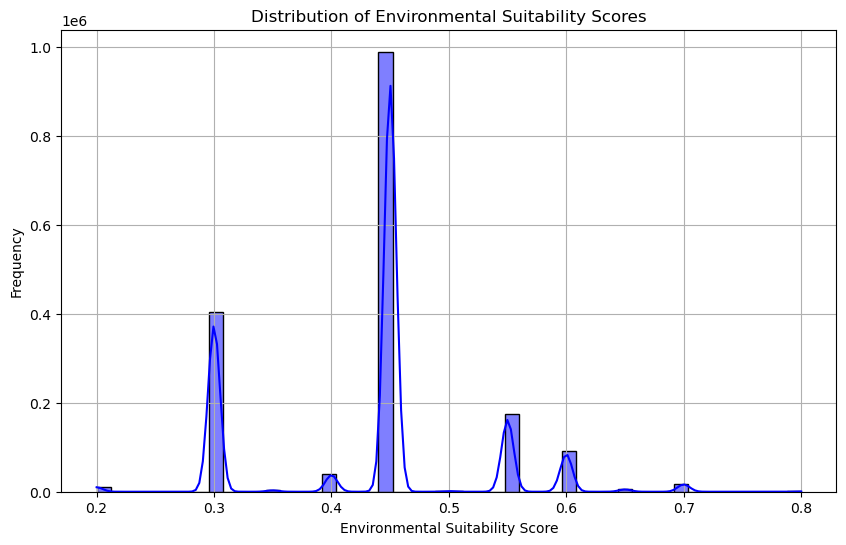

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(df['env_suitability_score'], bins=50, kde=True, color='blue')
plt.title('Distribution of Environmental Suitability Scores')
plt.xlabel('Environmental Suitability Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Land Use 

In [79]:
#function to plot distributions
def plot_multiple_land_use_distributions(df, columns, titles=None, palette='viridis', n_cols=2):
    """
    Plots the distribution of specified land use columns in the DataFrame in a grid layout.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list of str): List of column names to plot the distribution for.
        titles (list of str): List of titles for each plot. If None, column names are used as titles.
        palette (str): The color palette for the plots.
        n_cols (int): Number of columns in the grid layout.
    """
    n_rows = (len(columns) + n_cols - 1) // n_cols  #calculate the number of rows needed
    
    #create a figure and a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, column in enumerate(columns):
        value_counts = df[column].value_counts()
        sns.barplot(x=value_counts.index, y=value_counts.values, palette=palette, ax=axes[i])
        title = titles[i] if titles else column
        axes[i].set_title(title)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True)

    #remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739219 entries, 0 to 1739218
Data columns (total 35 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   soil_moisture                            float64
 1   NDBI                                     float64
 2   BU                                       float64
 3   Roughness                                float64
 4   Slope                                    float64
 5   NDVI                                     float64
 6   LST                                      float64
 7   UHI                                      float64
 8   UTFVI                                    float64
 9   NDWI                                     float64
 10  SAVI                                     float64
 11  lulc_classes                             int64  
 12  Amenity                                  object 
 13  GHI (kWh/m2)                             float64
 14  CH4_column_volume_

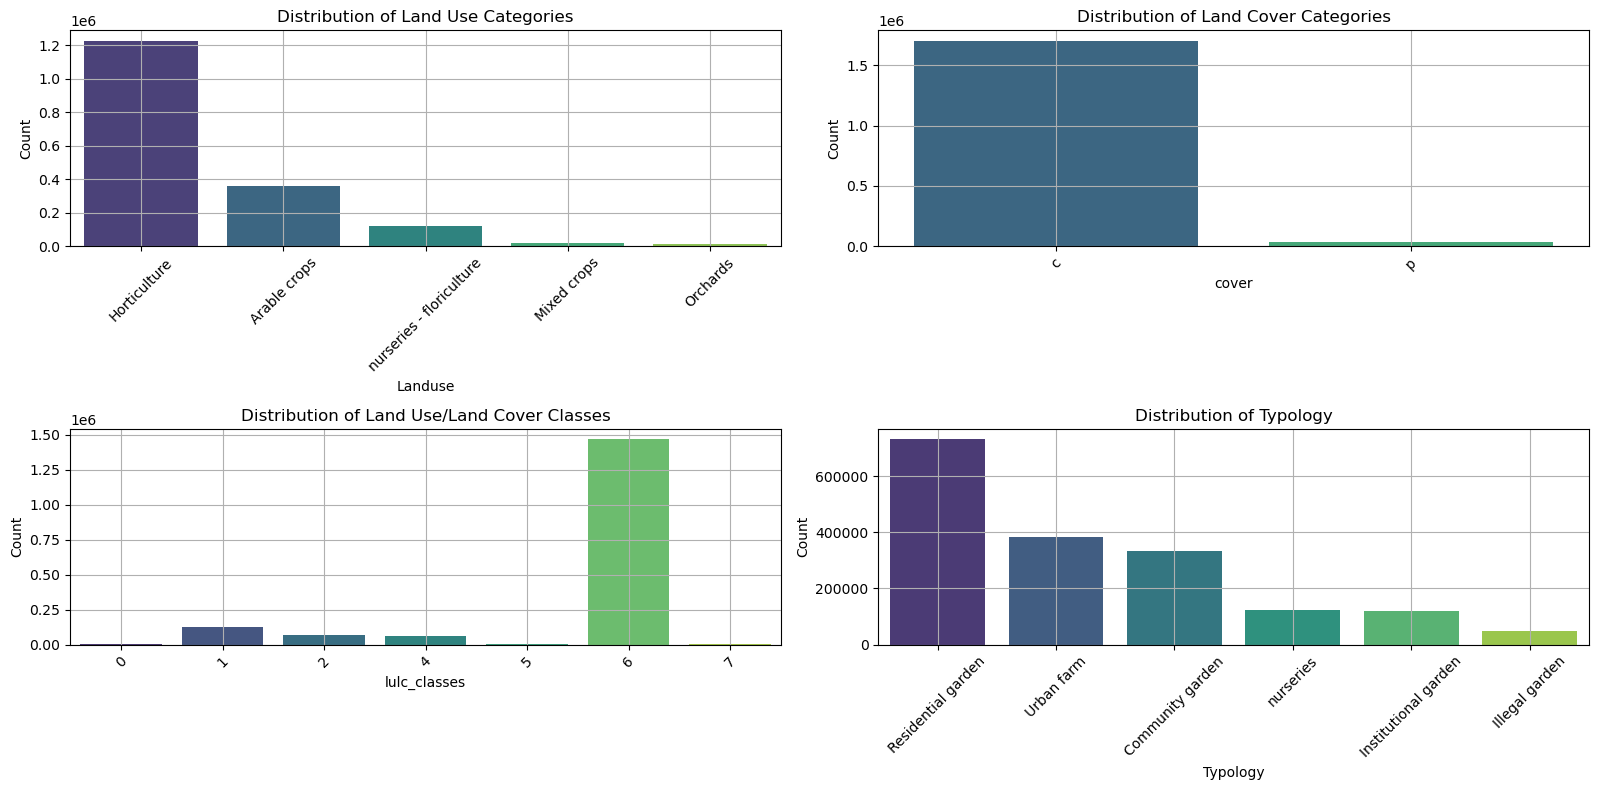

In [84]:
columns = ['Landuse', 'cover', 'lulc_classes', 'Typology']
titles = titles = ['Distribution of Land Use Categories', 'Distribution of Land Cover Categories',
                   'Distribution of Land Use/Land Cover Classes', 'Distribution of Typology' ]
plot_multiple_land_use_distributions(df, columns, titles=titles, n_cols=2)

In [91]:
df['lulc_classes'].value_counts()

lulc_classes
6    1469514
1     126800
2      66277
4      63386
0       6435
7       6075
5        732
Name: count, dtype: int64

In [87]:
# Function to plot the distribution of a given column
def plot_distribution(df, column, title="Distribution", bins=50, kde=True):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=bins, kde=kde, color='blue')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


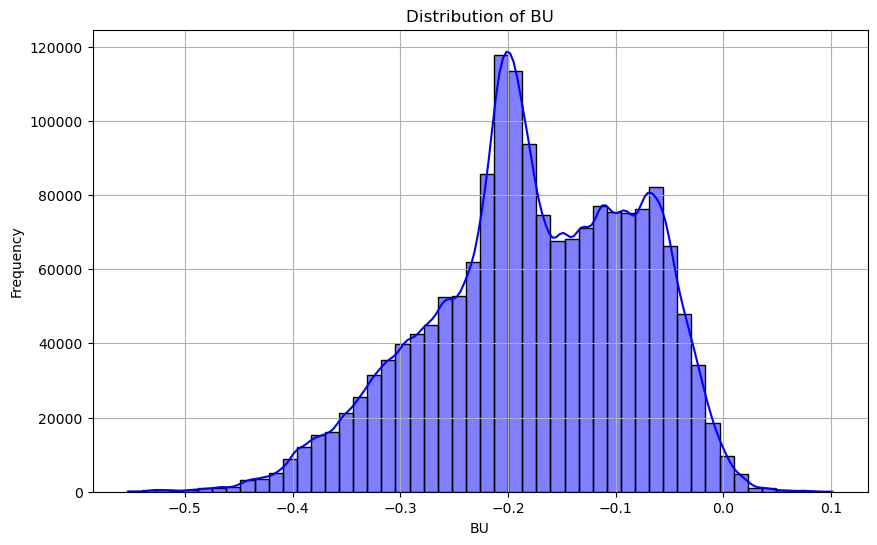

In [88]:
plot_distribution(df, 'BU', title='Distribution of BU')

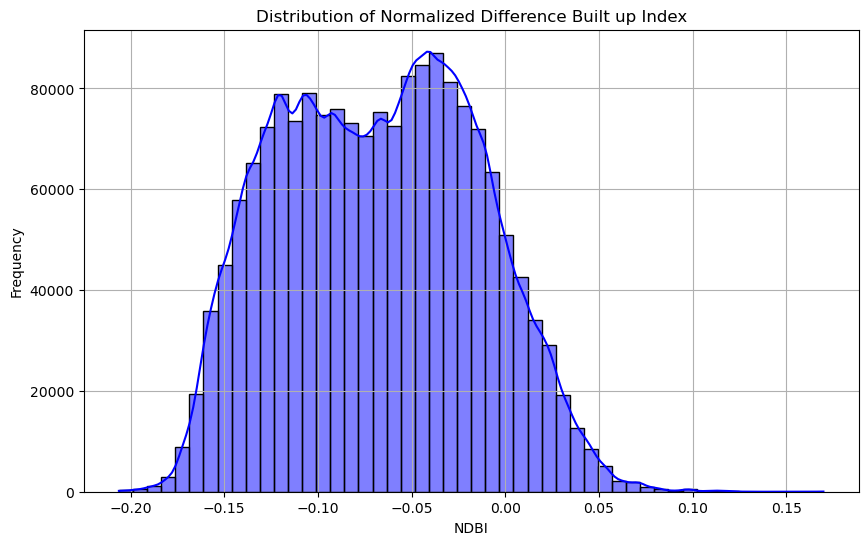

In [89]:
plot_distribution(df, 'NDBI', title='Distribution of Normalized Difference Built up Index')

Looking at distributions of BU and NDBI as well as the lulc classes, if lulc classes follow google earch definitions: 


0	#419bdf	water
1	#397d49	trees
2	#88b053	grass
3	#7a87c6	flooded_vegetation
4	#e49635	crops
5	#dfc35a	shrub_and_scrub
6	#c4281b	built
7	#a59b8f	bare
8	#b39fe1	snow_and_ice

class 6 is built up areas, whereas most values for BU and NDBI are negative, indicating less build up and less urbanized areas. Since this is conflicting zones will be mapped and analyzed. 


In [93]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [113]:
df['Year'].value_counts()

Year
2007    1542756
2014     196463
Name: count, dtype: int64

In [114]:
# Separate data by year
df_2007 = df[df['Year'] == 2007]
df_2014 = df[df['Year'] == 2014]

# Convert the DataFrames to GeoDataFrames
gdf_2007 = gpd.GeoDataFrame(df_2007, geometry=gpd.points_from_xy(df_2007.Longitude, df_2007.Latitude), crs="EPSG:4326")
gdf_2014 = gpd.GeoDataFrame(df_2014, geometry=gpd.points_from_xy(df_2014.Longitude, df_2014.Latitude), crs="EPSG:4326")

# Reproject to Web Mercator for compatibility with basemaps
gdf_2007 = gdf_2007.to_crs(epsg=3857)
gdf_2014 = gdf_2014.to_crs(epsg=3857)

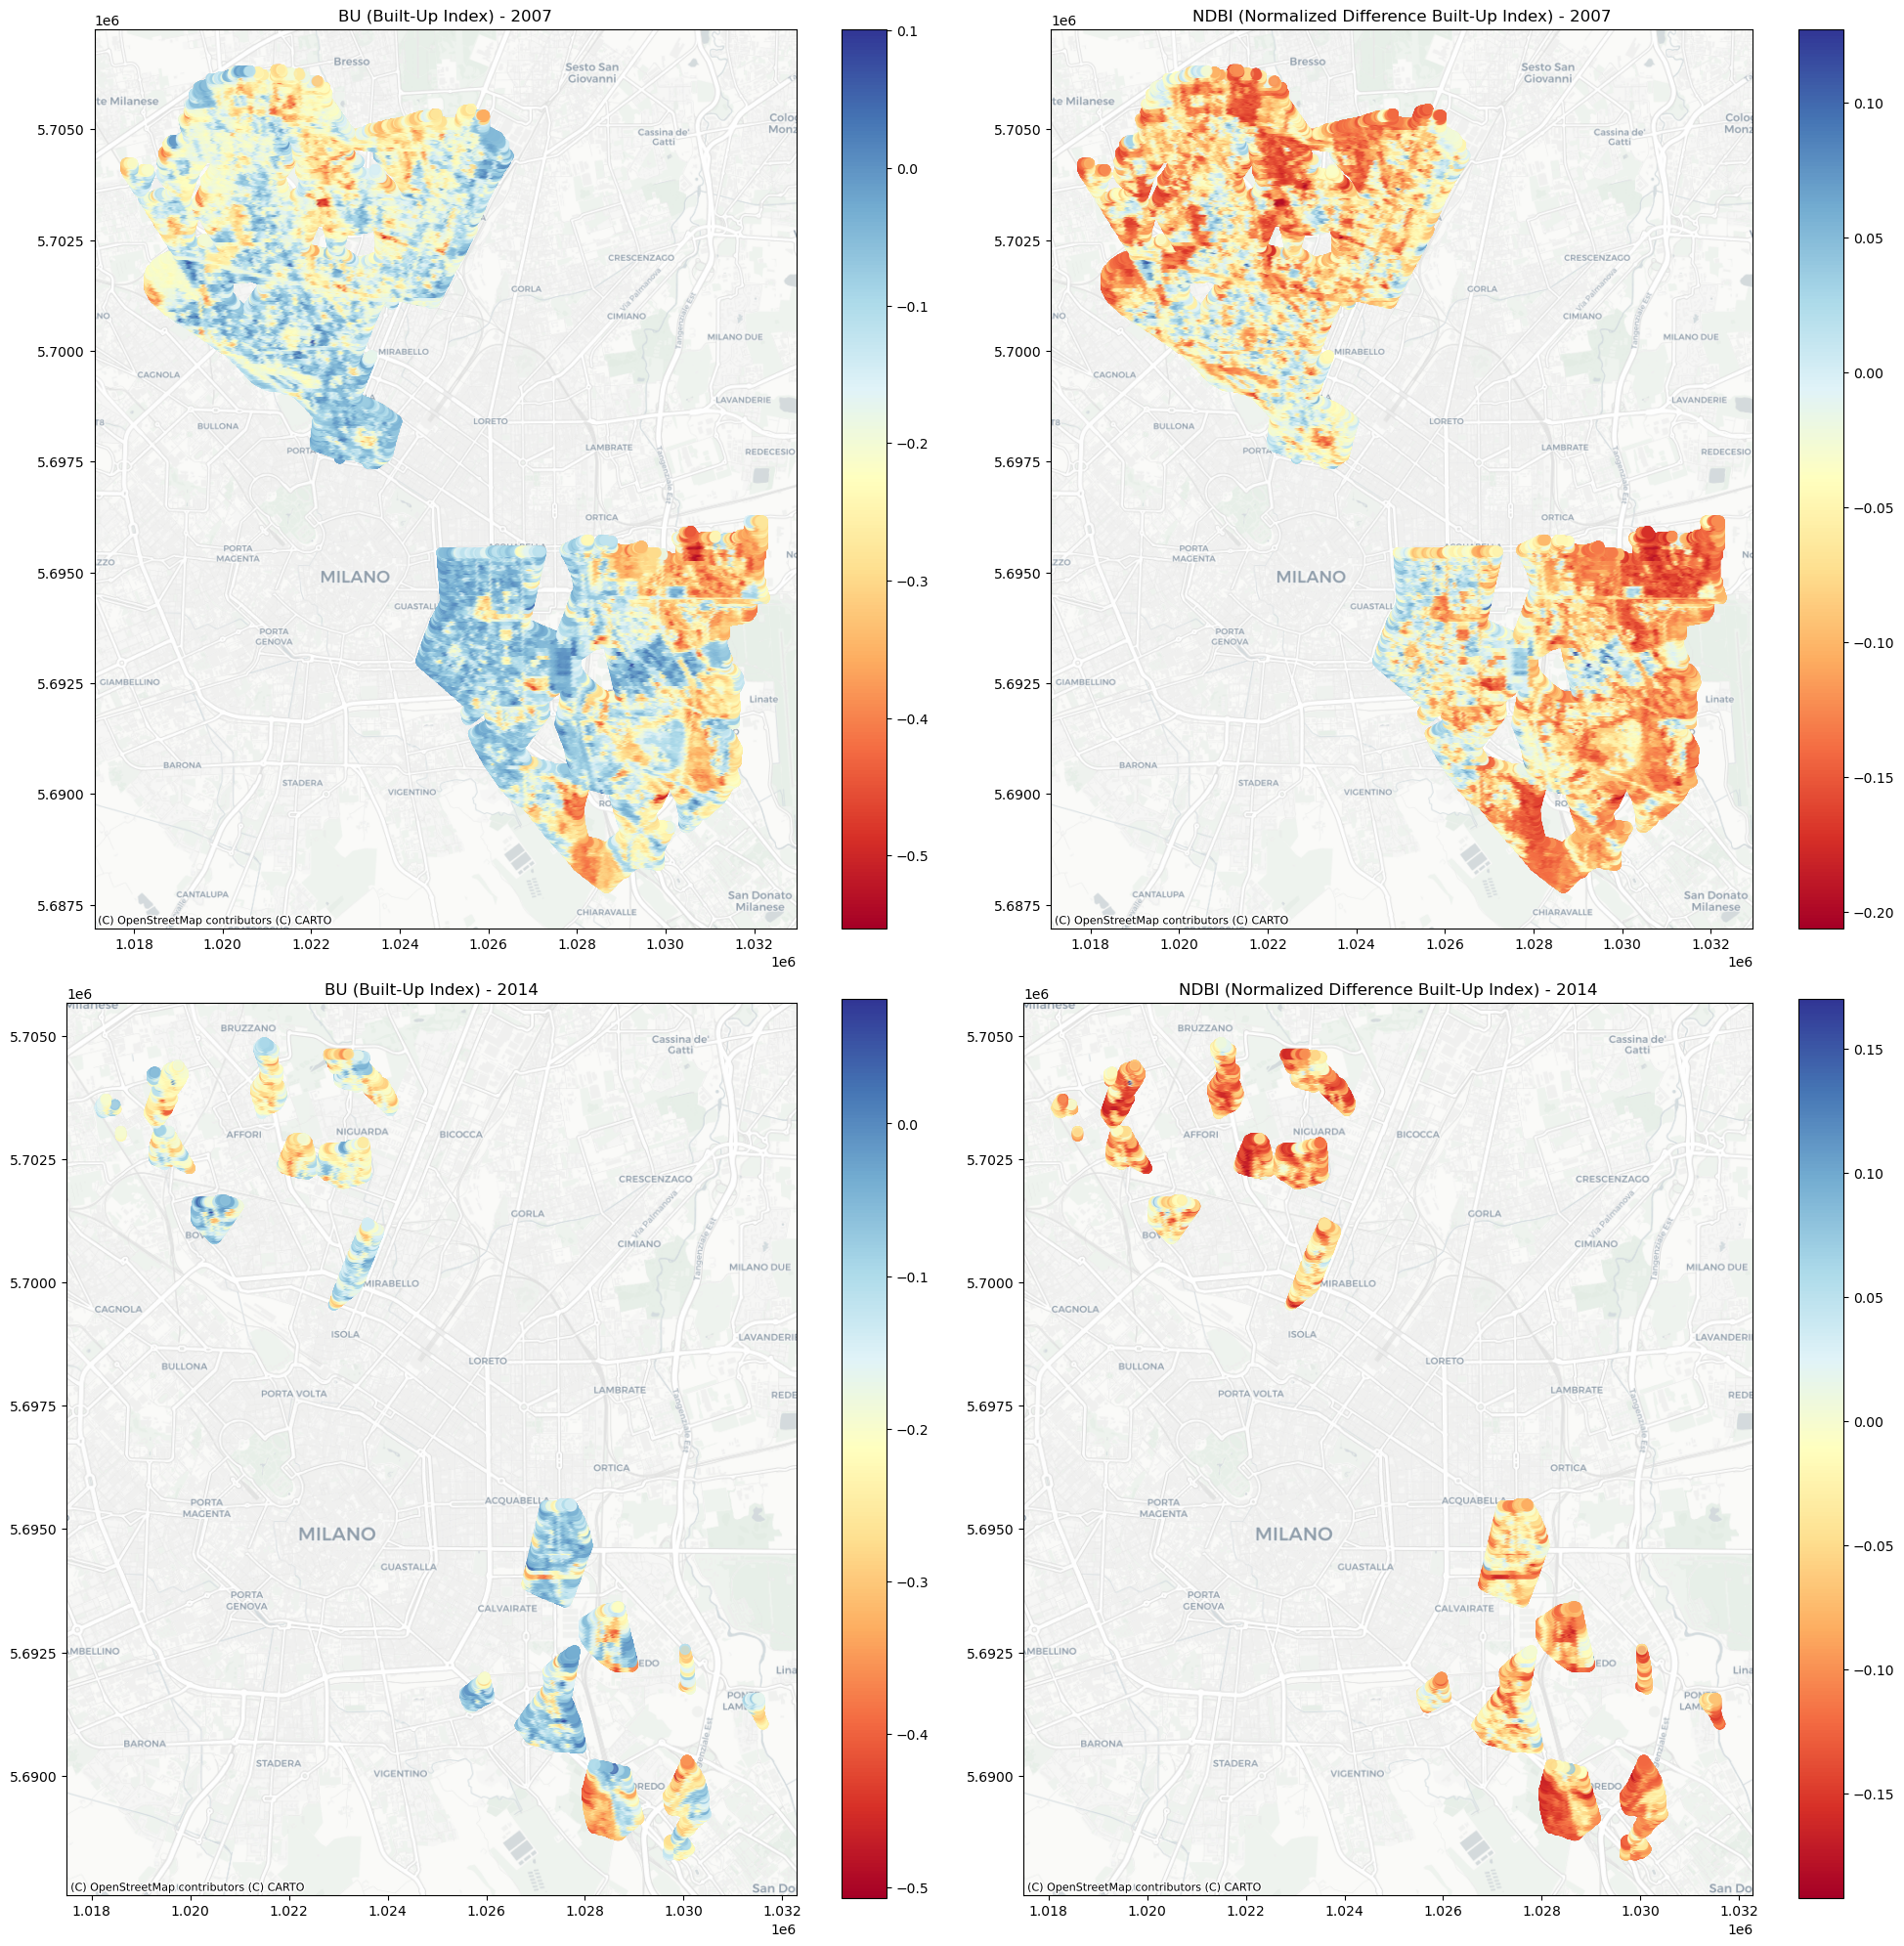

In [115]:
# Plot the GeoDataFrames with basemaps for 2007 and 2014
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

# Plot BU for 2007
gdf_2007.plot(ax=ax[0, 0], column='BU', cmap='RdYlBu', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax[0, 0], source=ctx.providers.CartoDB.Positron, crs=gdf_2007.crs.to_string())
ax[0, 0].set_title('BU (Built-Up Index) - 2007')

# Plot NDBI for 2007
gdf_2007.plot(ax=ax[0, 1], column='NDBI', cmap='RdYlBu', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax[0, 1], source=ctx.providers.CartoDB.Positron, crs=gdf_2007.crs.to_string())
ax[0, 1].set_title('NDBI (Normalized Difference Built-Up Index) - 2007')

# Plot BU for 2014
gdf_2014.plot(ax=ax[1, 0], column='BU', cmap='RdYlBu', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax[1, 0], source=ctx.providers.CartoDB.Positron, crs=gdf_2014.crs.to_string())
ax[1, 0].set_title('BU (Built-Up Index) - 2014')

# Plot NDBI for 2014
gdf_2014.plot(ax=ax[1, 1], column='NDBI', cmap='RdYlBu', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax[1, 1], source=ctx.providers.CartoDB.Positron, crs=gdf_2014.crs.to_string())
ax[1, 1].set_title('NDBI (Normalized Difference Built-Up Index) - 2014')

# Show the plots
plt.tight_layout()
plt.show()

Appears that there is more data available from 2007. Not sure on accuracy of indicies for built up area, when comparing to google maps, NDBI does look accurate. 

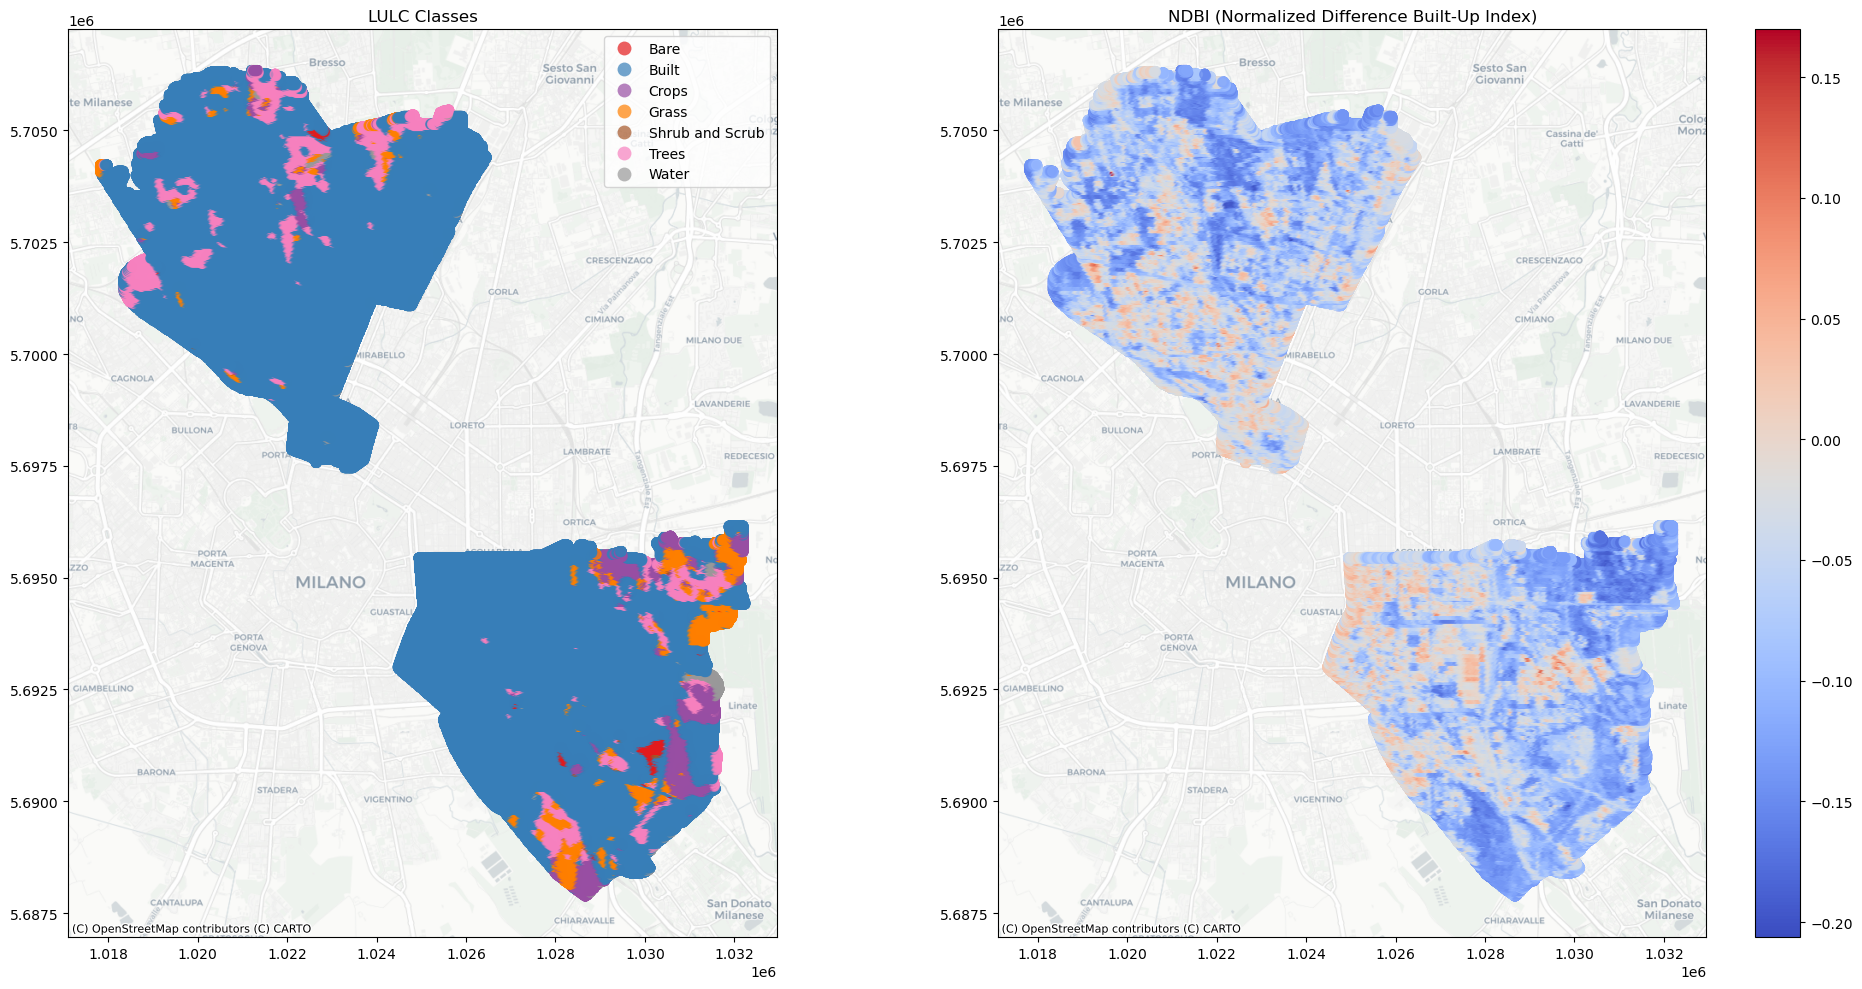

In [116]:
#look at lulc classes, for possible use in lnad use suitability score
#Define a mapping for the LULC class labels
lulc_class_labels = { #from google earth metadata
    0: 'Water',
    1: 'Trees',
    2: 'Grass',
    3: 'Flooded Vegetation',
    4: 'Crops',
    5: 'Shrub and Scrub',
    6: 'Built',
    7: 'Bare',
    8: 'Snow and Ice'
}

# Add LULC class labels to the DataFrame
df['lulc_class_labels'] = df['lulc_classes'].map(lulc_class_labels)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")

# Reproject to Web Mercator for compatibility with basemaps
gdf = gdf.to_crs(epsg=3857)

# Plot LULC Classes
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot LULC classes
gdf.plot(ax=ax[0], column='lulc_class_labels', cmap='Set1', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
ax[0].set_title('LULC Classes')

# Plot NDBI values
gdf.plot(ax=ax[1], column='NDBI', cmap='coolwarm', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
ax[1].set_title('NDBI (Normalized Difference Built-Up Index)')

# Show the plots
plt.tight_layout()
plt.show()

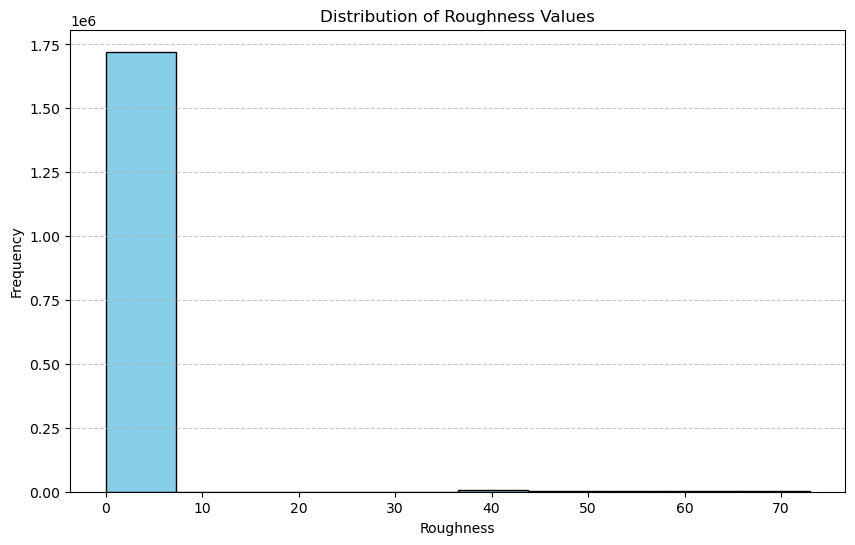

In [118]:
#roughness
plt.figure(figsize=(10, 6))
plt.hist(df['Roughness'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Roughness Values')
plt.xlabel('Roughness')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Based on LULC classes mapping and NDBI, it appears that NDBI < about -0.10 aligns with classes that are not class 6 (built). 
Roughness appears to perhaps be normalized? For Built up area, land use suitablity score the following approach will be used: 
- BU and LULC are the same, BU will be dropped
- score will be calculated on Lulc_classes that do not equal 6(and possibly do not equal 2 -> grass, as grass is usually a public park) and NDBI < -0.10 


In [119]:
#land use suitability score
#condition LULC classes
condition_lulc = ~df['lulc_classes'].isin([6,2]) #is not in 6 or 2
#condition ndbi
condition_ndbi = df['NDBI'] < -0.10 

#suitability score
df['land_suitability_score'] = condition_lulc & condition_ndbi
#convert boolean to integer (1 -> suitable, 0 -> not suitable)
df['land_suitability_score'] = df['land_suitability_score'].astype(int)

In [120]:
df['land_suitability_score'].value_counts()

land_suitability_score
0    1558660
1     180559
Name: count, dtype: int64

In [123]:
#percentage of data set with suitable land use: 
suitable_land = df['land_suitability_score'].sum()
entire = len(df)
percent_land_suitable = (suitable_land/entire)*100
print('percent of dataset with suitable land use score:', percent_land_suitable)

percent of dataset with suitable land use score: 10.381613816316404


Land use is a very important factor in considering urban agriculture, as only 10% of the data appears to display suitable land use, the data set is imbalanced and this will be considered in model training. 

### Amenities

In [135]:
import plotly.express as px

In [136]:
amenity_counts = df['Amenity'].value_counts().reset_index()
amenity_counts.columns = ['Amenity', 'Count']

#plot the distribution of amenities using Plotly with a log scale for the y-axis
fig = px.bar(amenity_counts, x='Amenity', y='Count', title='Distribution of Amenities',
             labels={'Amenity': 'Amenity', 'Count': 'Frequency'}, color='Count',
             log_y=True)

#update layout for better readability
fig.update_layout(xaxis_tickangle=-45)
fig.show()

Water point has a frequency of 193 in entire data set, drinking water has 196137, however drinking water might not have infrastructure or be suitable for irrigation. 

In [140]:
df.to_csv('urban_agriculture_suitability.csv', index=False)
